In [72]:
import tensorflow as tf
import numpy as np
import os
from skimage.io import imread, imsave
from skimage.transform import resize
from tensorflow.keras.models import load_model
import cv2
from sklearn.model_selection import train_test_split

In [73]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS = 3

In [74]:
training_images_names = os.listdir('./data/Training_Images')
testing_images_names = os.listdir('./data/Testing_Images')

In [75]:
X_train = np.zeros((len(training_images_names), IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype='uint8')
y_train = np.zeros((len(training_images_names), IMG_HEIGHT, IMG_WIDTH, 1))

In [76]:
for i, n in enumerate(training_images_names):
    img = imread(os.path.join('./data/Training_Images/', n))
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, CHANNELS), mode='constant', preserve_range=True)
    fn = str(n.split('.')[0]) + '.png'
    mask = imread(os.path.join('./data/masks/', fn))
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant')

    X_train[i] = img
    y_train[i] = mask
X_test = np.zeros((len(testing_images_names), IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype='uint8')

In [78]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#contracting path
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)


c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)


c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5_1 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5_1 = tf.keras.layers.Dropout(0.3)(c5_1)
c5_2 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5_1)
c5_3 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_2)
c5_4 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_3 )
c5_5 = tf.keras.layers.concatenate([c5_1,c5_4])


#expanding path
u4 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5_5)
u4 = tf.keras.layers.concatenate([u4,c4])
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)
u4 = tf.keras.layers.Dropout(0.2)(u4)
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)


u3 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(u4)
u3 = tf.keras.layers.concatenate([u3,c3])
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)
u3 = tf.keras.layers.Dropout(0.2)(u3)
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)


u2 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(u3)
u2 = tf.keras.layers.concatenate([u2,c2])
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)


u1 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(u2)
u1 = tf.keras.layers.concatenate([u1,c1])
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)

output = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(u1)

model = tf.keras.Model(inputs=[inputs],outputs=[output])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 256, 256,  │        448 │ lambda_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256, 256,  │          0 │ conv2d_44[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_20[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128, 128,  │          0 │ conv2d_46[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_21[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64, 64,    │          0 │ conv2d_48[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_22[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 32, 32,    │          0 │ conv2d_50[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_23[0][0]

 Total params: 4,563,569 (17.41 MB)

 Trainable params: 4,563,569 (17.41 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
results = model.fit(X_train, y_train, batch_size=16, epochs=100)
model.save('models/human_segmentation_non-aug_100_v2.h5')

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6087 - loss: 0.6540
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7005 - loss: 0.5907
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7158 - loss: 0.5305
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7383 - loss: 0.4760
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7627 - loss: 0.4614
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7814 - loss: 0.4478
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7997 - loss: 0.4168
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8077 - loss: 0.3999
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7726 - loss: 0.4519
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7892 - loss: 0.4297
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8109 - loss: 0.3914
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy:

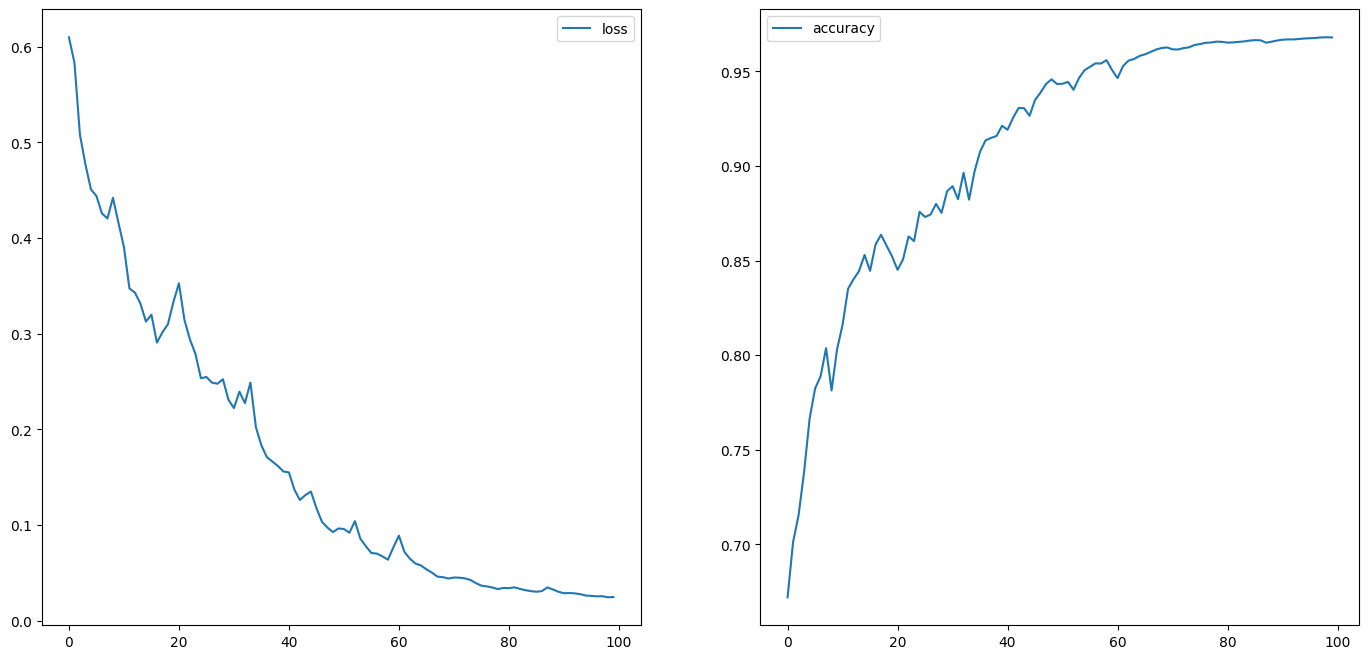

In [82]:
import matplotlib.pyplot as plt
fig, (a1, a2) = plt.subplots(1, 2, figsize=(17, 8))
a1.plot(np.arange(0, 100), results.history['loss'], label='loss')
a2.plot(np.arange(0, 100), results.history['accuracy'], label='accuracy')
a1.legend()
a2.legend()
plt.savefig('losses_and_accuracies_100_v2.png')

In [86]:
for i, n in enumerate(testing_images_names):
    img = imread(os.path.join('./data/Testing_Images', n))
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, CHANNELS), mode='constant', preserve_range=True)
    X_test[i] = img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


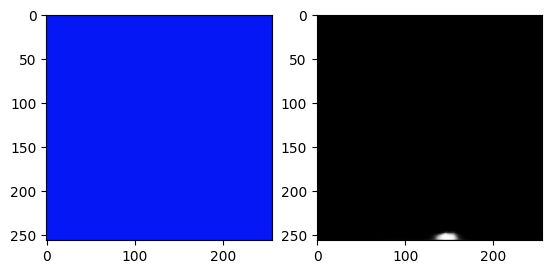

In [88]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming model is already defined

if len(X_test) == 0:
    print("X_test is empty. Please provide data.")
else:
    # Specify the index of the image you want to use
    image_index = 4  # Change this to the index of the specific image you want to use

    if image_index >= len(X_test):
        print(f"Invalid image index. Index must be less than {len(X_test)}")
    else:
        fig, (a1, a2) = plt.subplots(1, 2)

        a1.imshow(X_test[image_index])

        (h, w, c) = X_test[image_index].shape
        i = X_test[image_index].reshape((1, h, w, c))

        pred = model.predict(i)

        a2.imshow(pred.reshape(pred.shape[1:-1]), cmap='gray')

        # Specify the folder path where you want to save the images
        folder_path = "generated_images"

        # Create the folder if it doesn't exist
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Save the generated image
        plt.savefig(os.path.join(folder_path, f"generated_image_{image_index}.png"))

        plt.show()
